In [1]:
import base64
import io
import os
from io import BytesIO
from time import time
from typing import Union

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from PIL import Image

In [ ]:
!wget -O anh-con-cho-51.jpg https://hoanghamobile.com/tin-tuc/wp-content/uploads/2024/04/anh-con-cho-51.jpg

--2025-05-07 23:14:45--  https://hoanghamobile.com/tin-tuc/wp-content/uploads/2024/04/anh-con-cho-51.jpg
Resolving hoanghamobile.com (hoanghamobile.com)... 103.28.37.130
Connecting to hoanghamobile.com (hoanghamobile.com)|103.28.37.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125309 (122K) [image/jpeg]
Saving to: ‘anh-con-cho-51.jpg.1’

anh-con-cho-51.jpg. 100%[===================>] 122.37K  --.-KB/s    in 0.05s   

2025-05-07 23:14:45 (2.32 MB/s) - ‘anh-con-cho-51.jpg.1’ saved [125309/125309]



In [3]:
def get_image_base64(image_path: str) -> Union[str, None]:
    from PIL import Image

    try:
        with Image.open(image_path) as img:
            if img.mode != "RGB":
                img = img.convert("RGB")
            img.thumbnail((1024, 1024))
            buffered = io.BytesIO()
            img.save(buffered, format="JPEG")
            img_byte = buffered.getvalue()
            return base64.b64encode(img_byte).decode("utf-8")
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None
    except Exception as e:
        print(e)
        return None

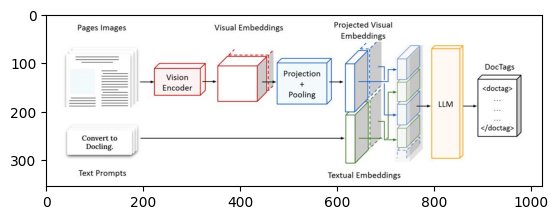

In [27]:
img_path = "../data/raw/imgs/image.png"
img = get_image_base64(img_path)
im = Image.open(BytesIO(base64.b64decode(img)))

import matplotlib.pyplot as plt

plt.imshow(im)
plt.show()

## With Gemini

In [36]:
def get_llm_vision():
    try:
        llm_vision = ChatGoogleGenerativeAI(
            model="gemini-1.5-flash",
            temperature=0.3,
            api_key=os.environ.get("GOOGLE_API_KEY"),
            max_output_tokens=100,
        )
        return llm_vision
    except Exception as e:
        print(e)
        return None

In [37]:
from pydantic import BaseModel, Field


def generate_caption_with_gemini(
    image_path: str,
    prompt: str = "Describe this image in detail to be used as a caption. Focus on the main subjects, actions, and setting.",
) -> Union[str, None]:
    class ImageCaption(BaseModel):
        image_captions: str = Field(description="The generated caption of image")

    # create llm_vision
    llm_vision = get_llm_vision()
    if not llm_vision:
        print("Model not found")
        return None
    llm_with_structed_output = llm_vision.with_structured_output(ImageCaption)

    image_b64 = get_image_base64(image_path)
    if not image_b64:
        return None

    message_content = [
        {
            "type": "text",
            "text": prompt,
        },
        {"type": "image_url", "image_url": f"data:image/jpeg;base64,{image_b64}"},
    ]

    human_message = HumanMessage(content=message_content)

    # sending request
    start_time = time()
    try:
        print("Sending Request")
        response = llm_with_structed_output.invoke([human_message])
        caption = response.image_captions
        end_time = time()
        print(f"Time taken: {end_time - start_time} seconds")
        # print(f"Response: {caption}")
        return caption.strip() if isinstance(caption, str) else str(caption).strip()
    except Exception as e:
        print("Error: ", e)
        return None

In [38]:
print(generate_caption_with_gemini(img_path))

Sending Request
Time taken: 2.5074708461761475 seconds
A diagram illustrating a process that converts pages of images and text prompts into DocTags using a vision encoder, visual embeddings, projection and pooling, textual embeddings, and an LLM.


## With Local Model

In [8]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
import torch
from accelerate.test_utils.testing import get_backend
from transformers import (
    AutoModelForCausalLM,  # mô hình chính
    AutoProcessor,
    BlipProcessor, 
    BlipForConditionalGeneration
)  # Lớn hơn AutoTokenizer (phù hợp cho mô hình MultiModal)


def get_llm_vision_local(checkpoint: str = "Salesforce/blip-image-captioning-base"):
    try:
        processor = AutoProcessor.from_pretrained(checkpoint)
        model = AutoModelForCausalLM.from_pretrained(checkpoint)
    except ValueError:
        processor = BlipProcessor.from_pretrained(checkpoint)
        model = BlipForConditionalGeneration.from_pretrained(checkpoint)
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

    return processor, model

In [22]:
processor, model = get_llm_vision_local()

/home/thangquang/CODE/multimodal-rag-baseline/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [25]:
def generate_caption_with_local_model(
    image_path: str,
    prompt: str = "Describe this image in detail to be used as a caption. Focus on the main subjects, actions, and setting.",
    processor_and_model: Union[tuple, None] = None,
) -> str:
    if not processor_and_model:
        processor, model = get_llm_vision_local()
    else:
        processor, model = processor_and_model
    start_time = time()
    img_for_local = Image.open(image_path)
    device, _, _ = get_backend()
    # Encode the prompt with the image data
    inputs = processor(text=prompt, images=img_for_local, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    end_time = time()
    print(f"Time taken: {end_time - start_time} seconds")
    return generated_caption

In [31]:
print(generate_caption_with_local_model(
    image_path=img_path, 
    prompt="a photography of",
    processor_and_model=(processor, model)
))

Time taken: 1.527705192565918 seconds
a diagram of the process
